In [ ]:
# Your legend mapping #Copy over into plotting logic depending on data used 
legend_map = { 
    "No Ligand": "No ligand",
    "1uM NADPH": "1uM",
    "2uM NADPH": "2uM",
    "5uM NADPH": "5uM",
    "10uM NADPH": "10uM",
    "30uM NADPH": "30uM",
    "50uM NADPH": "50uM",
    "100uM NADPH": "100uM",
    "200uM NADPH": "200uM"
}

legend_map = { 
    "No ligand": "No ligand",
    "30uM NADPH": "NADPH"
    "20uM Cytochrome c": "Cytochrome c"
    "7.5mM NADH": "NADH"
    "15mM NADH": "NADH"
    "30uM NADPH + 20uM Cytochrome c": "NADPH + Cytochrome c"
    "7.5mM NADH + 20uM Cytochrome c": "NADH + Cytochrome c"
    "15mM NADH + 20uM Cytochrome c": "NADH + Cytochrome c"
}

In [1]:
import pandas as pd
from collections import defaultdict

# Long-format DSF data
df_dsf = pd.read_csv("dsf_plate13_long.tsv", sep='\t')  # Well | Temperature | Fluorescence

contents = pd.read_csv("contentsmap_5.txt", sep='\t')

# Clean headers
contents.columns = (
    contents.columns
    .str.strip()              # remove leading/trailing spaces
    .str.replace('\u00a0', ' ', regex=False)  # fix non-breaking spaces
)

In [2]:
contents = contents[['Well', 'Condition Variable 1', 'Condition Variable 2']]

# Merge
df = df_dsf.merge(contents, on='Well', how='left')
#Run this to exclude negative conditions from the statistical analysis
df = df[~df["Well"].str.startswith("H")]

df["Treatment"] = (
    df["Condition Variable 1"].fillna("") +
    " | " +
    df["Condition Variable 2"].fillna("")
).str.strip(" |")

print(df["Treatment"].unique())

['CPR1 | No Ligand' 'CPR1 | 0.75uM Cytochrome c' 'CPR1 | 1uM Cytochrome c'
 'CPR1 | 2uM Cytochrome c' 'CPR1 | 5uM Cytochrome c'
 'CPR1 | 10uM Cytochrome c' 'CPR1 | 20uM Cytochrome c'
 'CPR1 | 50uM Cytochrome c' 'CPR1 | 100uM Cytochrome c' 'CPR2 | No Ligand'
 'CPR2 | 0.75uM Cytochrome c' 'CPR2 | 1uM Cytochrome c'
 'CPR2 | 2uM Cytochrome c' 'CPR2 | 5uM Cytochrome c'
 'CPR2 | 10uM Cytochrome c' 'CPR2 | 20uM Cytochrome c'
 'CPR2 | 50uM Cytochrome c' 'CPR2 | 100uM Cytochrome c']


In [137]:
condition_order = [
    "No Ligand",
    "30uM NADPH",
    "20uM Cytochrome c",
    "7.5mM NADH",
    "15mM NADH",
    "30uM NADPH + 20uM Cytochrome c",
    "7.5mM NADH + 20uM Cytochrome c",
    "15mM NADH + 20uM Cytochrome c"
]

In [49]:
condition_order = [
    "No Ligand",
    "1uM NADPH",
    "2uM NADPH",
    "5uM NADPH",
    "10uM NADPH",
    "30uM NADPH",
    "50uM NADPH",
    "100uM NADPH",
    "200uM NADPH",
    
]

In [3]:
condition_order = [
    "No Ligand",
    "0.75uM Cytochrome c",
    "1uM Cytochrome c",
    "2uM Cytochrome c",
    "5uM Cytochrome c",
    "10uM Cytochrome c",
    "20uM Cytochrome c",
    "50uM Cytochrome c",
    "100uM Cytochrome c", 
]

In [4]:
#Derivative Calculation with Savitzky-Golay Derivative-- makes peaks more symmetric  
from scipy.signal import savgol_filter
import numpy as np

def compute_neg_derivative(group, window=11, poly=3):
    temp = group["Temperature"].values
    fl = group["Fluorescence"].values

    dF_dT = savgol_filter(
        fl,
        window_length=window,
        polyorder=poly,
        deriv=1,
        delta=np.mean(np.diff(temp))
    )

    # IMPORTANT: return a Series aligned to the original index
    return pd.Series(-dF_dT, index=group.index)

df["neg_dF_dT"] = (
    df.groupby("Well", group_keys=False)[["Temperature", "Fluorescence"]]
      .apply(compute_neg_derivative)
)

In [5]:
from scipy.signal import find_peaks
import numpy as np

def annotate_unfolding_transitions(
    x, y,
    min_depth=-5,     # absolute dF/dT threshold
    Tmin=30,
    Tmax=72
):
    # Restrict temperature range
    mask = (x >= Tmin) & (x <= Tmax)
    x_filt = x[mask]
    y_filt = y[mask]

    if len(x_filt) < 5:
        return []

    # Keep only negative derivative (unfolding)
    y_unfold = np.where(y_filt < 0, y_filt, 0)

    # Detect negative peaks (troughs)
    min_abs_depth = 5
    peaks, properties = find_peaks(-y_unfold, height=min_abs_depth)

    if len(peaks) == 0:
        return []

    # Collect Tm and depth
    transitions = [(x_filt[i], y_filt[i]) for i in peaks]

    # Sort by temperature to assign Transition 1, 2, etc.
    transitions = sorted(transitions, key=lambda t: t[0])

    return transitions

transition_rows = []

for protein in df["Condition Variable 1"].unique():
    df_p = df[df["Condition Variable 1"] == protein]

    for cond in df_p["Condition Variable 2"].unique():
        df_c = df_p[df_p["Condition Variable 2"] == cond]

        for well, df_well in df_c.groupby("Well"):
            x = df_well["Temperature"].values
            y = df_well["neg_dF_dT"].values

            transitions = annotate_unfolding_transitions(
                x, y,
                min_depth=-5,
                Tmin=30,
                Tmax=72
            )

            for i, (tm, depth) in enumerate(transitions, start=1):
                transition_rows.append({
                    "Protein": protein,
                    "Condition": cond,
                    "Well": well,
                    "Transition": f"Transition {i}",  # label by temperature order
                    "Tm": tm,
                    "Depth": depth,
                    "Abs_Depth": abs(depth)
                })

df_transitions = pd.DataFrame(transition_rows)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
print(df_transitions)

   Protein            Condition Well    Transition    Tm       Depth  \
0     CPR1            No Ligand   A1  Transition 1  49.0  -60.951721   
1     CPR1            No Ligand   A1  Transition 2  61.0 -142.385062   
2     CPR1            No Ligand   B1  Transition 1  48.5  -63.267409   
3     CPR1            No Ligand   B1  Transition 2  61.5 -166.590548   
4     CPR1            No Ligand   C1  Transition 1  46.5  -46.539977   
5     CPR1            No Ligand   C1  Transition 2  61.5 -151.026457   
6     CPR1  0.75uM Cytochrome c   A2  Transition 1  48.5  -63.359172   
7     CPR1  0.75uM Cytochrome c   A2  Transition 2  61.0 -143.005389   
8     CPR1  0.75uM Cytochrome c   B2  Transition 1  48.5  -71.578512   
9     CPR1  0.75uM Cytochrome c   B2  Transition 2  61.0 -170.519992   
10    CPR1  0.75uM Cytochrome c   C2  Transition 1  48.5  -52.616399   
11    CPR1  0.75uM Cytochrome c   C2  Transition 2  61.0 -121.853147   
12    CPR1     1uM Cytochrome c   A3  Transition 1  47.5  -66.09

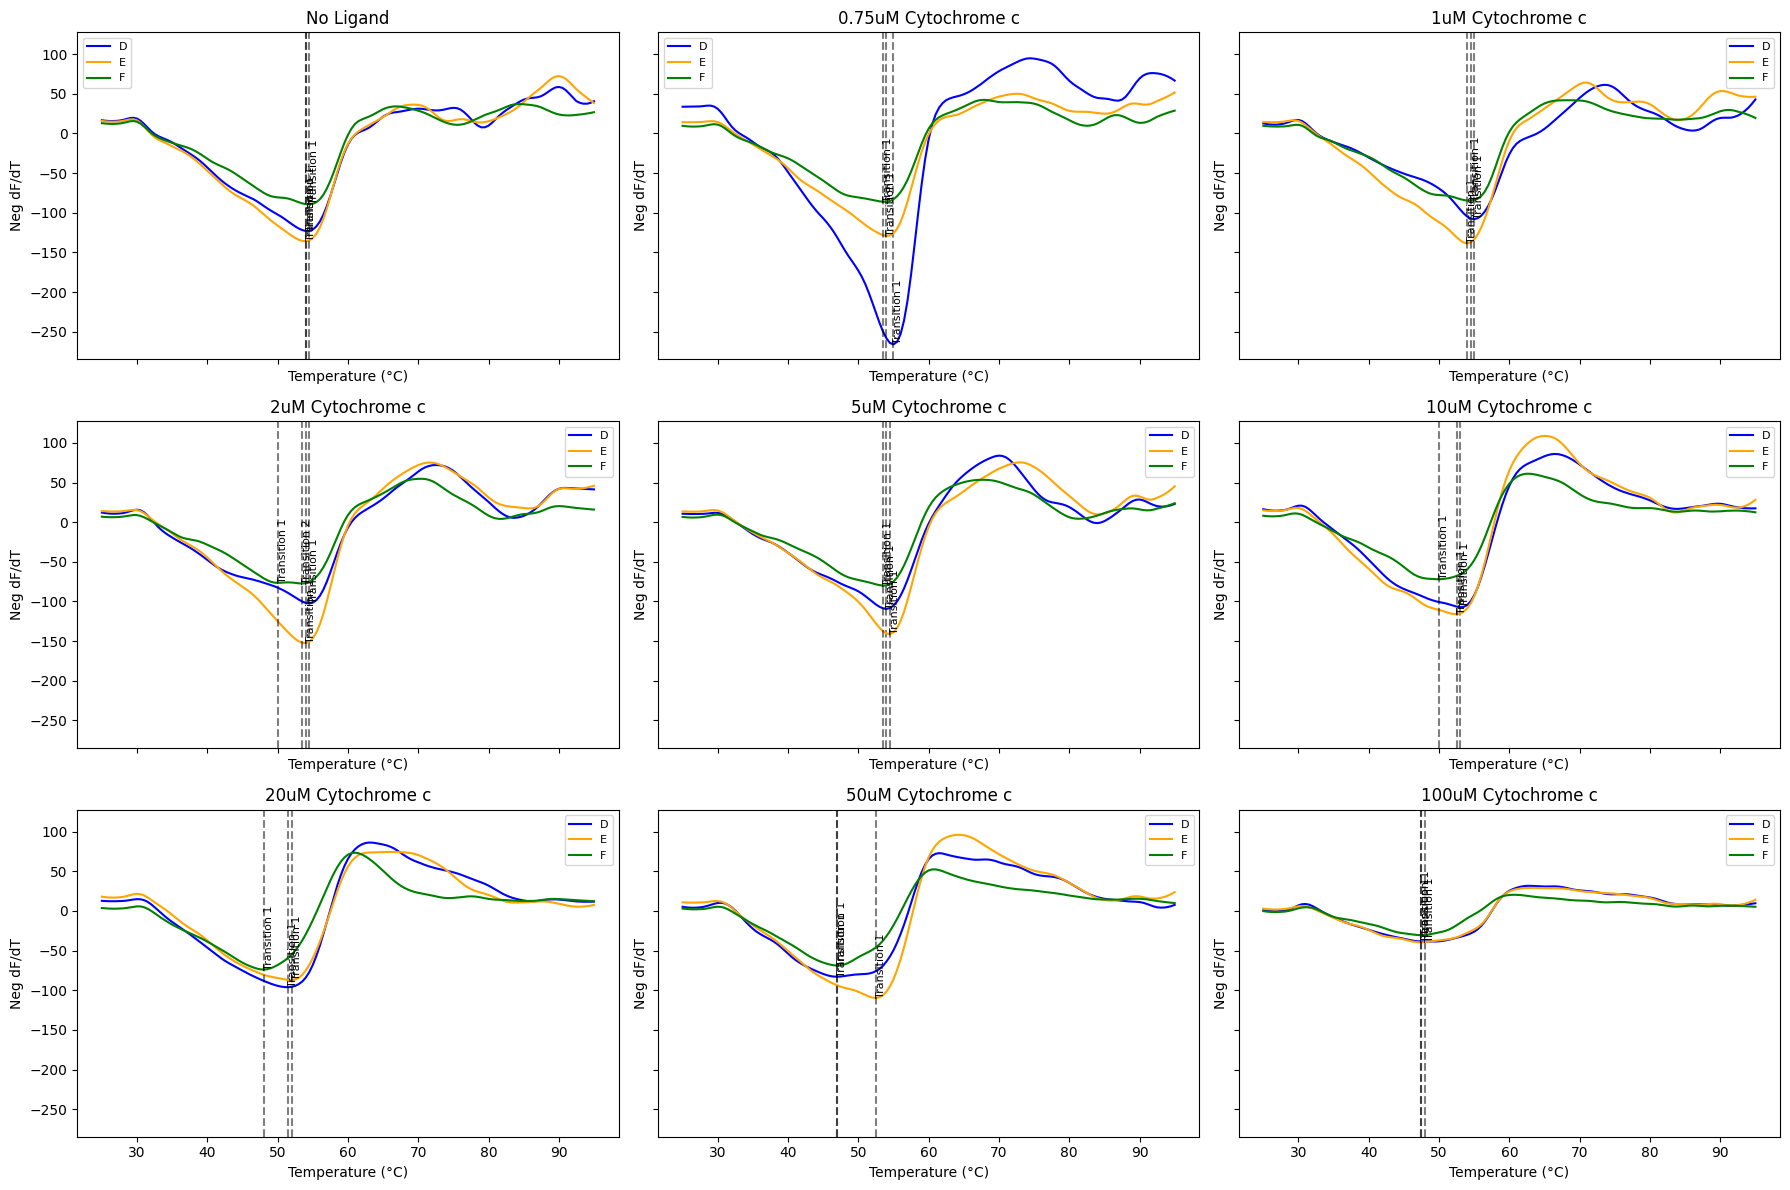

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
import matplotlib.pyplot as plt

### PLOT CPRs SEPARATELY--NO AVERAGE CURVE
#Condition order
condition_order = [
    "No Ligand",
    "0.75uM Cytochrome c",
    "1uM Cytochrome c",
    "2uM Cytochrome c",
    "5uM Cytochrome c",
    "10uM Cytochrome c",
    "20uM Cytochrome c",
    "50uM Cytochrome c",
    "100uM Cytochrome c", 
]

# Filter for CPR
df_cpr2 = df[df["Condition Variable 1"] == "CPR2"]
df_trans_cpr2 = df_transitions[df_transitions["Protein"] == "CPR2"]

# Consistent colors for replicates
rep_colors = {"D": "blue", "E": "orange", "F": "green"}

fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, cond in enumerate(condition_order):
    ax = axes[i]
    df_cond = df_cpr2[df_cpr2["Condition Variable 2"] == cond]

    # Plot replicates D, E, F only
    for well_prefix, color in rep_colors.items():
        # Select wells starting with this prefix
        df_well = df_cond[df_cond["Well"].str.startswith(well_prefix)]
        if df_well.empty:
            continue
        ax.plot(df_well["Temperature"], df_well["neg_dF_dT"], label=well_prefix, color=color)

        # Overlay transitions for this replicate
        transitions_well = df_trans_cpr2[
            (df_trans_cpr2["Condition"] == cond) &
            (df_trans_cpr2["Well"].str.startswith(well_prefix))
        ]
        for _, row in transitions_well.iterrows():
            ax.axvline(row["Tm"], color='k', linestyle='--', alpha=0.5)
            ax.text(row["Tm"], row["Depth"], row["Transition"], rotation=90,
                    verticalalignment='bottom', fontsize=8)

    ax.set_title(f"{cond}")
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Neg dF/dT")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
# Save figure with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fig.savefig(f"protein_melting_curves_{timestamp}.png", dpi=1200, bbox_inches="tight")
fig.savefig(f"protein_melting_curves_{timestamp}.eps", dpi=1200, bbox_inches="tight")

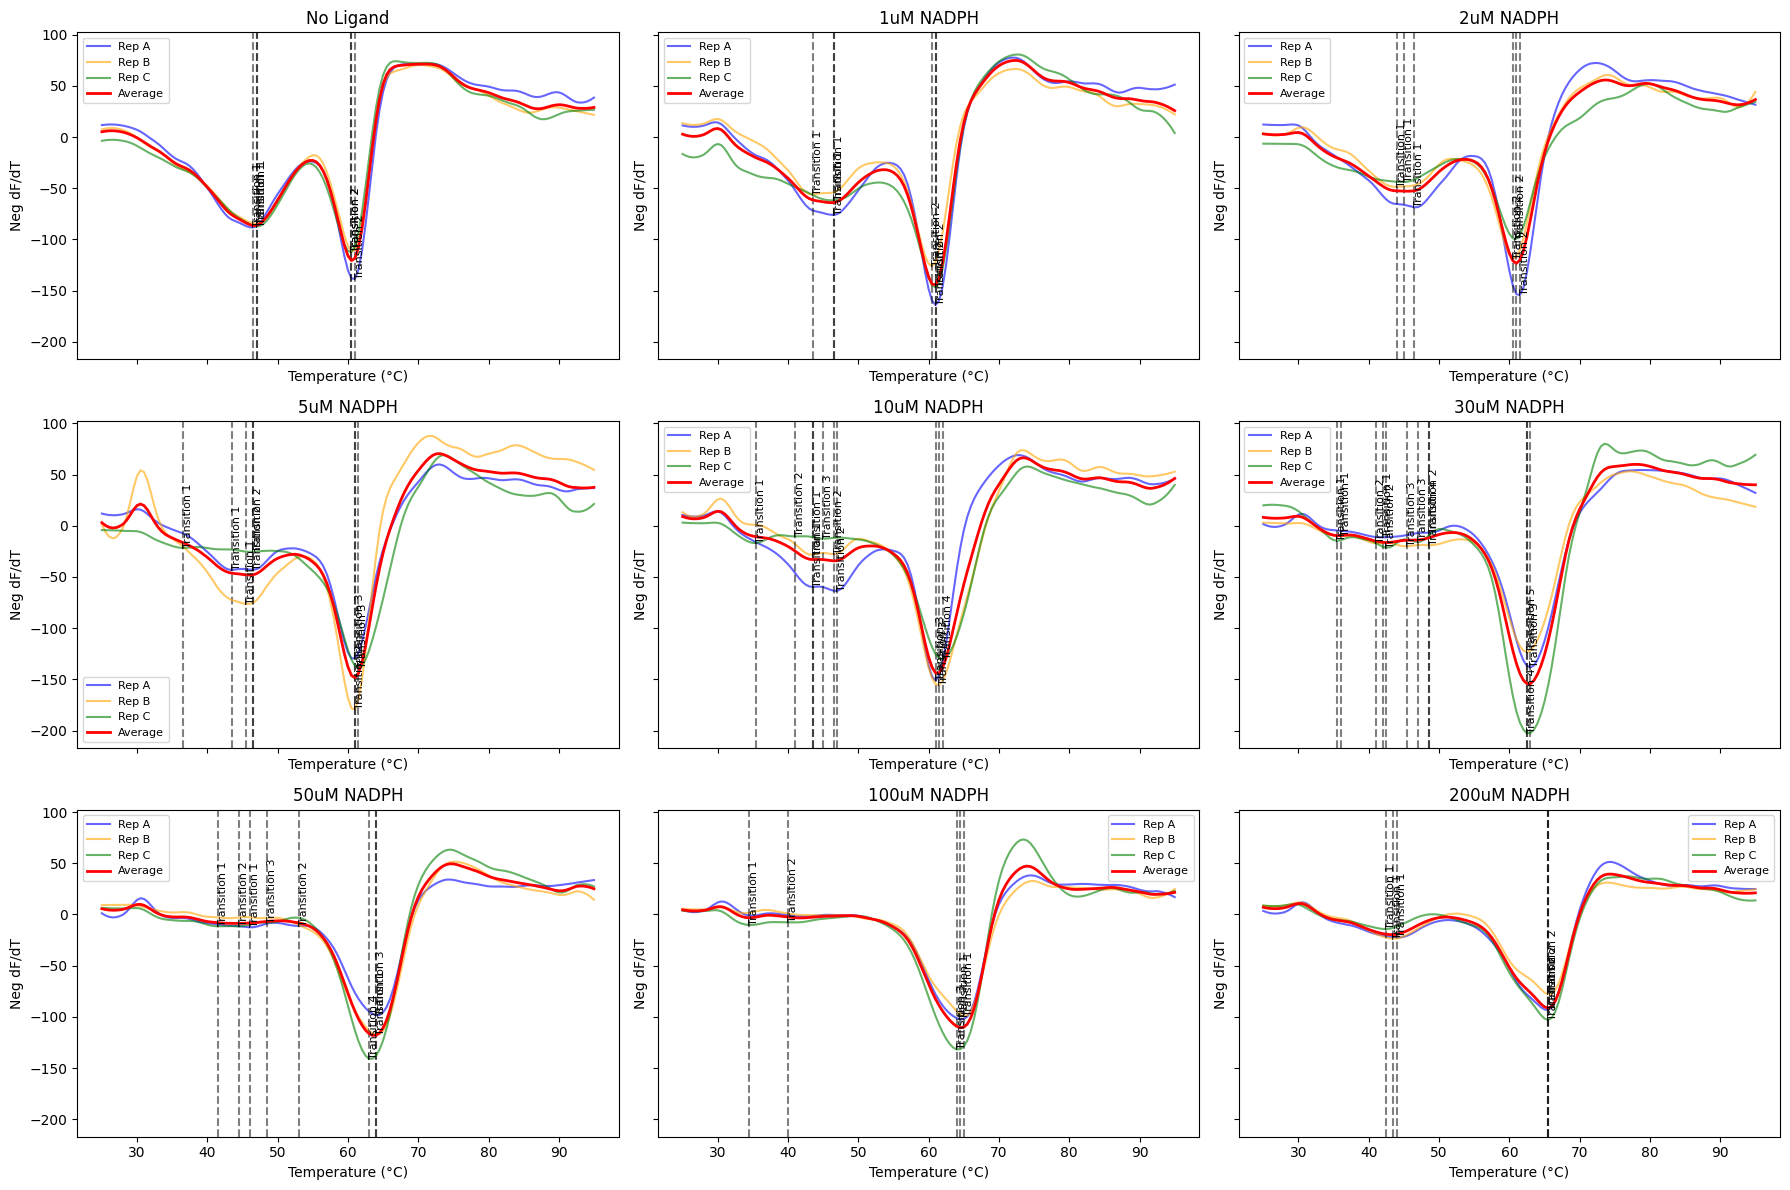

In [10]:
import matplotlib.pyplot as plt

### PLOT CPRs SEPARATELY--WITH AVERAGE CURVE
# Condition order
condition_order = [
    "No Ligand",
    "1uM NADPH",
    "2uM NADPH",
    "5uM NADPH",
    "10uM NADPH",
    "30uM NADPH",
    "50uM NADPH",
    "100uM NADPH",
    "200uM NADPH",
]

# Filter for CPR2 only
df_cpr2 = df[df["Condition Variable 1"] == "CPR1"]
df_trans_cpr2 = df_transitions[df_transitions["Protein"] == "CPR1"]

# Consistent colors for replicates
rep_colors = {"A": "blue", "B": "orange", "C": "green"}

fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, cond in enumerate(condition_order):
    ax = axes[i]
    df_cond = df_cpr2[df_cpr2["Condition Variable 2"] == cond]

    # Plot replicates D, E, F
    for well_prefix, color in rep_colors.items():
        df_well = df_cond[df_cond["Well"].str.startswith(well_prefix)]
        if df_well.empty:
            continue
        ax.plot(df_well["Temperature"], df_well["neg_dF_dT"], 
                label=f"Rep {well_prefix}", color=color, alpha=0.6)

        # Overlay transitions
        transitions_well = df_trans_cpr2[
            (df_trans_cpr2["Condition"] == cond) &
            (df_trans_cpr2["Well"].str.startswith(well_prefix))
        ]
        for _, row in transitions_well.iterrows():
            ax.axvline(row["Tm"], color='k', linestyle='--', alpha=0.5)
            ax.text(row["Tm"], row["Depth"], row["Transition"], rotation=90,
                    verticalalignment='bottom', fontsize=8)

    # Compute average curve for this condition
    if not df_cond.empty:
        avg_curve = df_cond.groupby("Temperature")["neg_dF_dT"].mean()
        ax.plot(avg_curve.index, avg_curve.values, color='red', linewidth=2, label='Average')

    ax.set_title(f"{cond}")
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Neg dF/dT")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd

legend_map = {
    "No ligand": "No ligand",
    "0.75uM Cytochrome c": "0.75uM",
    "1uM Cytochrome c": "1uM",
    "2uM Cytochrome c": "2uM",
    "5uM Cytochrome c": "5uM",
    "10uM Cytochrome c": "10uM",
    "20uM Cytochrome c": "20uM",
    "50uM Cytochrome c": "50uM",
    "100uM Cytochrome c": "100uM"
}

#---ClEAN AND REFORMAT PEAK DATAFRAME FOR CALLING ONLY BIOLOGICALLY MEANINGFUL TRANSITIONS
# Parameters
MIN_ABS_DEPTH = 19.0

# Filter shallow/non meaningful transitions first
df_filtered = df_transitions[df_transitions["Abs_Depth"] >= MIN_ABS_DEPTH]

# -------------------------------------------------------
# Manual exclusion of artefactual peak for Cyt c Exp 1 dataset
# CPR2 + 2uM Cytochrome c, well F4
# First transition is part of a broad single unfolding event
# and is not biologically independent
# -------------------------------------------------------
#df_filtered = df_filtered[
   # ~(
    #    (df_filtered["Protein"] == "CPR2") &
     #   (df_filtered["Condition"] == "2uM Cytochrome c") &
      #  (df_filtered["Well"] == "F4") &
       # (df_filtered["Transition"] == "Transition 1")
      #)
#]

# Keep only the final two transitions per well
df_clean = (
    df_filtered
    .sort_values("Tm")
    .groupby(["Protein", "Condition", "Well"], as_index=False)
    .tail(2)
)

# Identify anchor wells (those with two transitions reported per condition)
anchor = df_clean.groupby(["Protein", "Condition", "Well"]).filter(lambda g: len(g) == 2)

# Compute anchor means for T1/T2
anchor_means = (
    anchor.groupby(["Protein", "Condition", "Transition"])["Tm"]
    .mean()
    .unstack()  # columns: Transition 1, Transition 2
)

# Relabel transition peaks based on this anchor
def assign_transitions(group, anchor_means):
    n = len(group)
    if n == 2:
        # Already 2 transitions, just label sequentially
        return group.assign(
            Transition=[f"Transition {i+1}" for i in range(2)]
        )
    elif n == 1:
        # Single transition: assign closest anchor T1/T2
        protein = group["Protein"].iloc[0]
        condition = group["Condition"].iloc[0]
        tm_val = group["Tm"].iloc[0]

        try:
            t1_mean = anchor_means.loc[(protein, condition), "Transition 1"]
            t2_mean = anchor_means.loc[(protein, condition), "Transition 2"]
        except KeyError:
            # Fallback if no anchors exist
            t1_mean, t2_mean = None, None

        if t1_mean is not None and t2_mean is not None:
            label = "Transition 1" if abs(tm_val - t1_mean) <= abs(tm_val - t2_mean) else "Transition 2"
        else:
            label = "Transition 1"

        return group.assign(Transition=[label])
    else:
        # Zero transitions, just return empty
        return group

# Apply anchor based transition labeling 
df_clean = (
    df_clean.groupby(["Protein", "Condition", "Well"], group_keys=False)
    .apply(lambda g: assign_transitions(g, anchor_means))
    .reset_index(drop=True)
)

# Aggregate for table output
summary = (
    df_clean.groupby(["Protein", "Condition", "Transition"])
    .agg(
        Mean_Tm=("Tm", "mean"),
        SEM_Tm=("Tm", lambda x: x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else np.nan),
        n=("Tm", "count")
    )
    .reset_index()
)

# Helper function to format table values
def format_tm(mean, sem, n):
    if np.isnan(mean):
        return "—"
    elif n > 1 and not np.isnan(sem):
        return f"{mean:.1f} ± {sem:.1f}"
    else:
        return f"{mean:.1f}"

# -------------------------------
# Pivot and format table for plotting
# -------------------------------
table_rows = []

for protein in summary["Protein"].unique():
    df_p = summary[summary["Protein"] == protein]

    for cond in condition_order:
        df_c = df_p[df_p["Condition"] == cond]

        if df_c.empty:
            continue

        # Grab transitions
        t1 = df_c[df_c["Transition"] == "Transition 1"]
        t2 = df_c[df_c["Transition"] == "Transition 2"]

        # Determine display strings
        if t1.empty and not t2.empty:
            # Only one transition present → always show in T2
            t1_str = "—"
            t2_str = format_tm(t2["Mean_Tm"].iloc[0], t2["SEM_Tm"].iloc[0], t2["n"].iloc[0])
        elif not t1.empty and t2.empty:
            # Only one transition present → assign to T2
            t1_str = "—"
            t2_str = format_tm(t1["Mean_Tm"].iloc[0], t1["SEM_Tm"].iloc[0], t1["n"].iloc[0])
        elif t1.empty and t2.empty:
            # No transitions called at all
            t1_str = t2_str = "—"
        else:
            # Both transitions present
            t1_str = format_tm(t1["Mean_Tm"].iloc[0], t1["SEM_Tm"].iloc[0], t1["n"].iloc[0])
            t2_str = format_tm(t2["Mean_Tm"].iloc[0], t2["SEM_Tm"].iloc[0], t2["n"].iloc[0])

        table_rows.append({
            "Protein": protein,
            "Condition": legend_map.get(cond, cond),
            "Melting Temp(s) °C": f"{t1_str} | {t2_str}"
        })

df_table = pd.DataFrame(table_rows)


C:\Users\betha\AppData\Local\Temp\ipykernel_1328\2004186019.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: assign_transitions(g, anchor_means))


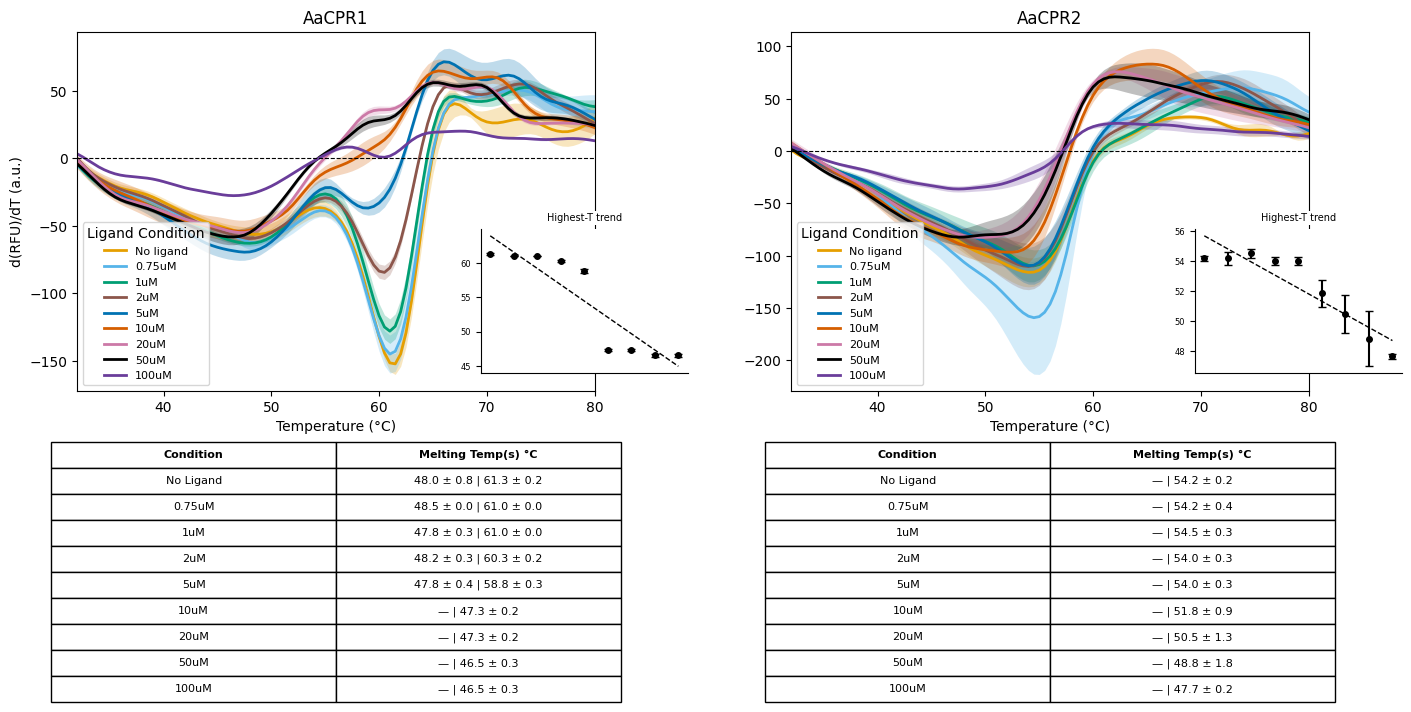

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import find_peaks
from scipy.stats import linregress
from collections import defaultdict

# -------------------------------
# Protein setup
# -------------------------------
proteins = ["CPR1", "CPR2"]

# Publication-friendly protein names
protein_display_names = {
    "CPR1": "AaCPR1",
    "CPR2": "AaCPR2"
}

#legend mapping
legend_map = {
    "No Ligand": "No ligand",
    "0.75uM Cytochrome c": "0.75uM",
    "1uM Cytochrome c": "1uM",
    "2uM Cytochrome c": "2uM",
    "5uM Cytochrome c": "5uM",
    "10uM Cytochrome c": "10uM",
    "20uM Cytochrome c": "20uM",
    "50uM Cytochrome c": "50uM",
    "100uM Cytochrome c": "100uM"
}

# Color-blind-friendly palette
cbf_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#8C564B",  # muted brown
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # pink/purple
    "#000000",  # black
    "#6A3D9A"   # deep violet
]

# -------------------------------
# Figure layout
# -------------------------------
fig, axes = plt.subplots(
    nrows=2,
    ncols=len(proteins),
    figsize=(14, 7),
    gridspec_kw={
        "height_ratios": [3, 1],
        "wspace": 0.08
    },
    constrained_layout=True
)

# -------------------------------
# Precompute color map
# -------------------------------
unique_labels = list(dict.fromkeys(legend_map.values()))
color_map = {
    label: cbf_colors[i % len(cbf_colors)]
    for i, label in enumerate(unique_labels)
}

protein_melt_temps = defaultdict(dict)

# -------------------------------
# Main derivative plots
# -------------------------------
for col, protein in enumerate(proteins):
    ax = axes[0, col]

    df_p = df[df["Condition Variable 1"] == protein]

    for cond2 in condition_order:
        if cond2 not in df_p["Condition Variable 2"].values:
            continue

        df_c = df_p[df_p["Condition Variable 2"] == cond2]
        if df_c.empty:
            continue

        stats = (
            df_c.groupby("Temperature")["neg_dF_dT"]
            .agg(["mean", "std", "count"])
            .dropna()
        )

        mean_curve = stats["mean"]
        sem_curve = stats["std"] / np.sqrt(stats["count"])

        x = mean_curve.index.values
        y = mean_curve.values
        label = legend_map.get(cond2, cond2)

        ax.plot(x, y, linewidth=2, label=label, color=color_map[label])
        ax.fill_between(
            x,
            y - sem_curve.values,
            y + sem_curve.values,
            color=color_map[label],
            alpha=0.25,
            linewidth=0
        )

    # Axis formatting
    ax.axhline(0, color="black", linestyle="--", linewidth=0.8)
    ax.set_xlim(32, 80)
    ax.set_title(protein_display_names.get(protein, protein))
    ax.set_xlabel("Temperature (°C)")
    if col == 0:
        ax.set_ylabel("d(RFU)/dT (a.u.)")

    ax.legend(
        fontsize=8,
        title="Ligand Condition",
        loc="lower left"
    )

# -------------------------------
# Tables (melting temps) 
# -------------------------------
for col, protein in enumerate(proteins):
    ax_table = axes[1, col]
    ax_table.axis("off")

    # Select protein-specific table data
    df_p = df_table[df_table["Protein"] == protein]
    rows = [list(r) for r in df_p[["Condition", "Melting Temp(s) °C"]].values.tolist()]
    
    # Create the table
    table = ax_table.table(
        cellText=rows,
        colLabels=["Condition", "Melting Temp(s) °C"],
        cellLoc="center",
        loc="center",
        colColours=["#FFFFFF", "#FFFFFF"]
    )
    
    # Style adjustments
    table.auto_set_font_size(False)
    table.set_fontsize(8)

    # Bold headers
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_text_props(weight='bold')

    # Adjust size for better readability
    table.scale(1.1, 1.6)

# Major peak trend inset
# -------------------------------
for col, protein in enumerate(proteins):
    ax_main = axes[0, col]

    ax_inset = ax_main.inset_axes([0.78, 0.05, 0.4, 0.4])

    x_vals = []
    y_major = []
    y_major_err = []

    df_p = df_clean[df_clean["Protein"] == protein]

    for cond in condition_order:
        df_cond = df_p[
            (df_p["Condition"] == cond) &
            (df_p["Transition"] == "Transition 2")
        ]

        if df_cond.empty:
            df_cond = df_p[
                (df_p["Condition"] == cond) &
                (df_p["Transition"] == "Transition 1")
            ]

        if df_cond.empty:
            x_vals.append(cond)
            y_major.append(np.nan)
            y_major_err.append(np.nan)
            continue

        temps = df_cond["Tm"].values
        y_major.append(np.mean(temps))
        if len(temps) > 1:
            y_major_err.append(np.std(temps, ddof=1) / np.sqrt(len(temps)))
        else:
            y_major_err.append(0)

        x_vals.append(cond)

    x_numeric = np.arange(len(x_vals))
    y_major = np.array(y_major)
    y_major_err = np.array(y_major_err)

    ax_inset.errorbar(
        x_numeric,
        y_major,
        yerr=y_major_err,
        fmt='o',
        color='black',
        capsize=3,
        markersize=4
    )

    valid = ~np.isnan(y_major)
    if np.sum(valid) > 1:
        slope, intercept, *_ = linregress(x_numeric[valid], y_major[valid])
        ax_inset.plot(
            x_numeric[valid],
            intercept + slope * x_numeric[valid],
            'k--',
            linewidth=1
        )

    ax_inset.tick_params(axis='x', bottom=False, labelbottom=False)
    ax_inset.tick_params(axis='y', labelsize=6)
    ax_inset.spines['top'].set_visible(False)
    ax_inset.spines['right'].set_visible(False)

    ax_inset.set_title(
        "Highest-T trend",
        fontsize=7,
        bbox=dict(facecolor='white', edgecolor='none', pad=1.5)
    )

plt.show()
# Save figure with timestamp
# Save figure with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
fig.savefig(f"protein_melting_curves_{timestamp}.png", dpi=1200, bbox_inches="tight")
fig.savefig(f"protein_melting_curves_{timestamp}.eps", dpi=1200, bbox_inches="tight")

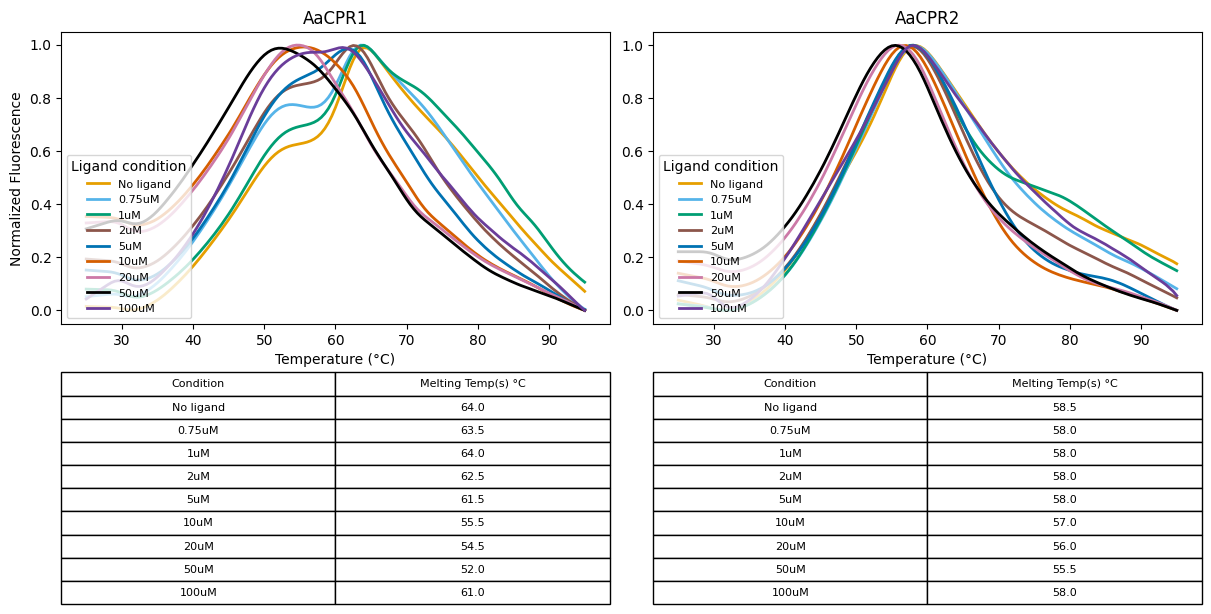

In [28]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# -------------------------------
# Supplementary figure:
# Normalized melt curves with melting temperature table
# -------------------------------

# -------------------------------
# Normalization function
# -------------------------------
def normalize_curve(fluorescence):
    return (
        (fluorescence - np.min(fluorescence)) /
        (np.max(fluorescence) - np.min(fluorescence))
    )

# -------------------------------
# Peak detection for normalized curves (maxima)
# -------------------------------
def annotate_peaks_max(x, y, prominence_factor=0.1, primary_only=True):
    peaks, props = find_peaks(
        y,
        prominence=np.nanmax(y) * prominence_factor
    )
    peak_temps = x[peaks]

    if len(peak_temps) == 0:
        return []

    if primary_only:
        primary_idx = np.argmax(y[peaks])
        return [peak_temps[primary_idx]]

    return list(peak_temps)

# -------------------------------
# Dictionary to store melting temperatures
# -------------------------------
protein_melt_temps_norm = {
    protein: {} for protein in proteins
}

# -------------------------------
# Figure setup
# Top row = curves, bottom row = table
# -------------------------------
fig, axes = plt.subplots(
    nrows=2,
    ncols=len(proteins),
    figsize=(12, 6),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True
)

# -------------------------------
# Loop through proteins and conditions
# -------------------------------
for col, protein in enumerate(proteins):
    ax = axes[0, col]

    df_p = df[df["Condition Variable 1"] == protein]

    for cond2 in condition_order:
        if cond2 not in df_p["Condition Variable 2"].values:
            continue

        df_c = df_p[df_p["Condition Variable 2"] == cond2]
        if df_c.empty:
            continue

        # Normalize each well
        norm_curves = []
        for well, group in df_c.groupby("Well"):
            norm_fl = normalize_curve(group["Fluorescence"].values)
            norm_curves.append(norm_fl)

        # Mean normalized curve
        mean_norm = np.mean(norm_curves, axis=0)
        x = group["Temperature"].values

        # Map labels to colors
        color_map = {
            label: cbf_colors[i % len(cbf_colors)]
            for i, label in enumerate(unique_labels)
        }

        # Plot mean curve
        label = legend_map.get(cond2, cond2)
        color = color_map[label]
        ax.plot(
            x,
            mean_norm,
            color=color,
            linewidth=2,
            label=label
        )

        # Compute melting temperature (primary max peak)
        peak_temps = annotate_peaks_max(
            x,
            mean_norm,
            prominence_factor=0.1,
            primary_only=True
        )
        protein_melt_temps_norm[protein][label] = peak_temps

    # Axis formatting
    ax.set_title(protein_display_names.get(protein, protein))
    ax.set_xlabel("Temperature (°C)")
    if col == 0:
        ax.set_ylabel("Normalized Fluorescence")

    ax.legend(
        fontsize=8,
        title="Ligand condition",
        loc="lower left"
    )

# -------------------------------
# Bottom row: melting temperature tables
# -------------------------------
for col, protein in enumerate(proteins):
    ax_table = axes[1, col]
    ax_table.axis("off")

    rows = []
    for cond, temps in protein_melt_temps_norm[protein].items():
        temps_str = ", ".join(
            [f"{t:.1f}" for t in temps]
        ) if temps else ""
        rows.append([cond, temps_str])

    table = ax_table.table(
        cellText=rows,
        colLabels=["Condition", "Melting Temp(s) °C"],
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)

plt.show()
